Michael Questions
 - why does finite differences take a 7X12 input as final layer? f_i(x): R^D-> R, no? not R^(DXE)?

In [2]:
# import standard libraries
!pip install autograd
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys

# import our libraries
import bayes_helpers as bh
from utils import generate_data
from utils import run_toy_nn
from feed_forward import Feedforward
from nlm import NLM

     |████████████████████████████████| 829 kB 20.4 MB/s 
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=e07248655e09e8affddc85c04bd4b3eb7745660ea1e7924c25d6c26e42a28359
  Stored in directory: /home/jovyan/.cache/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=eabf6927b37028391475417473369f58ae31b5588117c176d0025a35f740e657
  Stored in directory: /home/jovyan/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built autograd future
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [31]:
from nlm import NLM
from scipy.optimize import approx_fprime
class LUNA(NLM):
    """
    Fits LUNA Model; inherits from NLM and overrides the objective function
    
    Model Assumptions
     - Weights distributed normally
     - Ys distributed normally

     How to use:
      - run train() to create: 
            a) the NN MLE weights, found in self.ff.weights 
            b) self.posterior samples, the distribution for the weights in the last layer of NLM
     
      - run predict() to get distribution of ys, given x test
    """

    def __init__(self, prior_var, y_noise_var, architecture, random):
        #inherit from NLM, override objective func
        super().__init__(prior_var, y_noise_var, architecture, random, self.make_objective) 
        self.D, self.D_out, self.H = self.ff.D, architecture['output_dim'], architecture['width']

    def get_aux_funcs(self, W):
        '''
        Separates out weights and biases for each aux function
        
        Inputs: 
        - W = NumPy array of all weights weights [dim=(1, width H, input dimension D_in)]

        Returns:
        - res_w = a list where each element is a list of weights for a different aux func (D_out inner lists);  
                  each inner list should contain H weights (H = width of each network layer)
        - res_b = a list of aux func biases; should contain D_out elements (one bias for each aux func)
        ''' 
        res_w, res_b = [], []
        D, D_out, H = self.D, self.D_out, self.H
        index = D - (D_out*H + D_out) - 1
        for m in range(D_out):
            w_m = W[0][index + H*m:index + H*(m+1)]
            b_m = W[0][index + H*(m+1)]
            index += 1
            res_w.append(w_m)      
            res_b.append(b_m)
        return res_w, res_b

    def similarity_score(self, W):
        '''
        Calculates total sum of squared cosine similarity between all pairwise combinations of aux 
        functions
        
        Inputs: 
        - W = NumPy array of weights [dim=(1, width H, input dimension D_in)]

        Returns:
        - score = total cosine similarity squared across all pairs of functions [scalar]
        ''' 

        D, D_out, H = self.D, self.D_out, self.H 
        
        def default_finite_diff(f_auxes,layer):

            #f_auxs_of_layer = apply all aux funcs to final layer
            f_eval = f_auxes(layer)
            eps_matrix = np.random.normal(0,0.1,size=f_eval.shape)
            
            return (f_eval + eps_matrix) - f_eval)eps

            # this was the gradient w.r.t. one aux function
            grad_i = np.array([(f_i(layer + eps_i) - f_i(layer))/eps_i[d,:] for d in range(eps_i.shape[0])])
                 

        def cos_sim_sq(f_i, f_j, layer):
            '''
            Calculates square of cosine similarity between two functions
            
            Inputs: NOTE: f_i and f_j WILL CHANGE TO BE THE GRADIENT OF THE EACH AUX FUNCTION
            - f_i = function handle for a single aux function (defined in similarity_score)
            - f_j = function handle for a single aux function (defined in similarity_score)
            - layer = NumPy array of last hidden layer in network [dim=(1, width H, # of datapts)]

            Returns:
            - total = cosine similarity squared for two functions [scalar]
            ''' 
            layer = layer[0]
            eps_i = np.random.normal(0,0.1,size=layer.shape)
            eps_j = np.random.normal(0,0.1,size=layer.shape)
            # finite differences gradient for all the data in the layer
            #print(eps_i)
            #print(layer.shape)
            #print(f_i(layer))
            #grad_i = approx_fprime(layer, f_i, epsilon = np.random.normal(0, 0.1, size = layer.shape[0]))
            #grad_j = approx_fprime(layer, f_j, epsilon = np.random.normal(0, 0.1, size = layer.shape[0]))
            #print(grad_i)
            grad_i = np.array([(f_i(layer + eps_i) - f_i(layer))/eps_i[d,:] for d in range(eps_i.shape[0])])
            grad_j = np.array([(f_j(layer + eps_j) - f_j(layer))/eps_j[d,:] for d in range(eps_j.shape[0])])

            total = sum([ (np.dot(grad_i[:,k], grad_j[:,k].T)**2)/(np.dot(grad_i[:,k], grad_i[:,k].T) * np.dot(grad_j[:,k], grad_j[:,k].T)) for k in range(grad_i.shape[1])])

            return total

        # calculate square of cosine similarity for each pair of aux functions
        score = 0
        final_hidden_layer = self.ff.forward(W, x_train, final_layer_out=True)
        aux_func_weights, aux_func_biases = self.get_aux_funcs(W)

        # get all the aux_func_derivs as self.aux_func_derivs
        for i in range(D_out):
            grad_i
        # calc cos_sim_sq based on the self.aux_func_derivs

        for i in range(D_out):
            w_i = aux_func_weights[i]
            b_i = aux_func_biases[i]
            f_i = lambda layer : np.matmul(w_i, layer) + b_i#applying aux weights w_i to last hidden layer
            for j in range(i + 1, D_out):
                w_j = aux_func_weights[j]
                b_j = aux_func_biases[j]
                f_j = lambda layer : np.matmul(w_j, layer) + b_j#applying aux weights w_j to last hidden layer
                s = cos_sim_sq(f_i, f_j, final_hidden_layer)
                score += s
        return score
        
    def mean_mean_sq_error(self, W):
        '''
        Calculates average mean sq error across each output nodes (=the aux functions)
        
        Inputs: 
        - W = NumPy array of all weights weights [dim=(1, width H, input dimension D_in)]

        Returns:
        - mean_mse = mean of mean sq error for each aux function [scalar]
        ''' 
        D, D_out, H = self.D, self.D_out, self.H
        aux_outputs = self.ff.forward(W, x_train) #shape = (1,10,12)
        Y = np.tile(y_train, D_out).reshape(1, D_out, y_train.shape[1])

        # calculate squared error for each aux regressor, take mean
        mean_mse = np.mean(np.linalg.norm(Y - aux_outputs, axis=1)**2)

        return mean_mse

    def make_objective(self, x_train, y_train, reg_param):
        '''
        Makes objective function and AutoGrad  
        
        Inputs: 
        - W = NumPy array of all weights weights [dim=(1, width H, input dimension D_in)]

        Returns:
        - mean_mse = mean of mean sq error for each aux function [scalar]
        ''' 

        def objective(W, t):
            # L_luna(model) = L_fit(model) - L_similarity(model)
            reg_param = 0.1 #eventually this will become an input
            lambda_ = 0.1 #eventually this will become an input
            L_sim = lambda_*self.similarity_score(W)

            regularization_penalty = reg_param*np.linalg.norm(W)**2
            mean_mse = self.mean_mean_sq_error(W)
            L_fit = mean_mse - regularization_penalty

            return L_fit - L_sim

        return objective, grad(objective)

### Define Hyperameters

In [32]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 7
hidden_layers = 2
input_dim = 1
output_dim = 5 #number of auxiliary functions

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}
prior_var, y_noise_var = 3.0, 3.0
random = np.random.RandomState(0)
luna = LUNA(prior_var, y_noise_var, architecture, random)

In [33]:
df = pd.read_csv("HW8_data.csv")
x_train = np.array(df["x"])
y_train = np.array(df["y"])
x_test = np.linspace(x_train.min()-1,x_train.max()+1,200)

x_train = x_train.reshape((1, -1))
y_train = y_train.reshape((1, -1))
x_test = x_test.reshape((1, -1))

# 1500 iterations took 5 minutes

# gonna see how 6000 iterations does

# computes approx 5 iterations per second
params = {'step_size':3e-3, 
          'max_iteration':150, 
          'random_restarts':1,
          'optimizer':'adam'}

luna.train(x_train, y_train, params)

 Iteration 0 lower bound 1083.7087008942726; gradient mag: 3606.3235111433464
Done Training


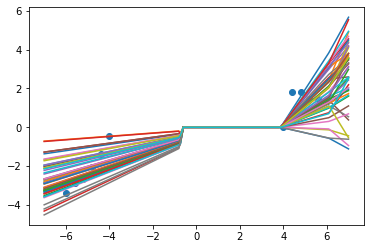

In [34]:
posterior_predictions, posterior_predictive_samples = luna.predict(x_test)
plt.scatter(x_train, y_train)
for i in range(50):
    plt.plot(x_test.flatten(), posterior_predictions[i,:])
plt.show()

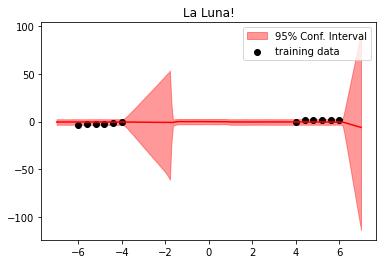

In [ ]:
# predict on the test x-values
bh.viz_pp_samples(x_train,y_train,x_test.flatten(),posterior_predictive_samples,'La Luna!')
